In [36]:
import warnings
warnings.filterwarnings("ignore")

In [1]:


from __future__ import print_function, division

import os
import numpy as np
from torchvision import datasets, transforms, models
import torchvision
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
import torch
import torch.utils.data
import torchvision.transforms as T
from torchinfo import summary
import copy
from PIL import Image
import matplotlib.pyplot as plt
import time

In [2]:
data_dir = "/mnt/chromeos/GoogleDrive/MyDrive/Datasets/models/images/"

In [31]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

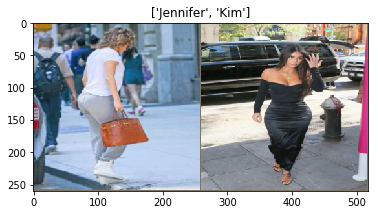

In [36]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)


imshow(out, title=[class_names[x] for x in classes])

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [38]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [39]:
# loading pretrained resnet-18 model from 
# https://arxiv.org/pdf/1512.03385.pdf
# and using it as a fixed feature extractor
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

In [16]:
summary(model_ft)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  (36,864)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  (36,864)
│    │    └─BatchNorm2d: 3-5             (128)
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  (36,864)
│    │    └─BatchNorm2d: 3-7             (128)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (36,864)
│    │    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11   

In [40]:
# Beginning size of each output sample is 1000
print(model_ft.fc.out_features)

# Finetuning the convnet by replacing last layer with custom layer for train
num_ftrs = model_ft.fc.in_features

# Setting size of each output sample is set to 3
model_ft.fc = nn.Linear(num_ftrs, 3)
print(model_ft.fc.out_features)

1000
3


In [42]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [43]:
image_classifier = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1491 Acc: 0.3000
val Loss: 0.9533 Acc: 0.6333

Epoch 1/24
----------
train Loss: 1.1120 Acc: 0.5000
val Loss: 0.9018 Acc: 0.6333

Epoch 2/24
----------
train Loss: 0.8592 Acc: 0.5667
val Loss: 1.2941 Acc: 0.6333

Epoch 3/24
----------
train Loss: 1.0027 Acc: 0.5500
val Loss: 1.1862 Acc: 0.5667

Epoch 4/24
----------
train Loss: 1.0326 Acc: 0.6500
val Loss: 1.2981 Acc: 0.5333

Epoch 5/24
----------
train Loss: 0.9609 Acc: 0.5833
val Loss: 1.7004 Acc: 0.4000

Epoch 6/24
----------
train Loss: 1.2167 Acc: 0.4167
val Loss: 1.5201 Acc: 0.6333

Epoch 7/24
----------
train Loss: 0.7825 Acc: 0.6333
val Loss: 1.4724 Acc: 0.6000

Epoch 8/24
----------
train Loss: 0.7713 Acc: 0.6667
val Loss: 1.6306 Acc: 0.6333

Epoch 9/24
----------
train Loss: 0.6017 Acc: 0.7333
val Loss: 1.5368 Acc: 0.6333

Epoch 10/24
----------
train Loss: 0.4117 Acc: 0.8667
val Loss: 1.3478 Acc: 0.6333

Epoch 11/24
----------
train Loss: 0.7128 Acc: 0.6667
val Loss: 1.4077 Acc: 0.5667

Ep

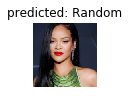

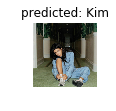

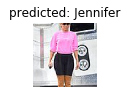

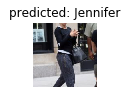

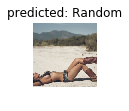

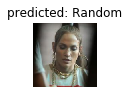

In [44]:
visualize_model(image_classifier)

plt.ioff()
plt.show()